## Part 1

In [7]:
import numpy as np
import random
from numpy.random import default_rng
from numpy.random import standard_normal
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso,LassoCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
import random 
import math

In [2]:

def simulate_data(n, p, rng, *, sparsity=0.95, SNR=2.0, beta_scale=5.0):
    """Simulate data for Project 3, Part 1.

    Parameters
    ----------
    n : int
        Number of samples
    p : int
        Number of features
    rng : numpy.random.Generator
        Random number generator (e.g. from `numpy.random.default_rng`)
    sparsity : float in (0, 1)
        Percentage of zero elements in simulated regression coefficients
    SNR : positive float
        Signal-to-noise ratio (see explanation above)
    beta_scale : float
        Scaling for the coefficient to make sure they are large

    Returns
    -------
    X : `n x p` numpy.array
        Matrix of features
    y : `n` numpy.array
        Vector of responses
    beta : `p` numpy.array
        Vector of regression coefficients
    """
    X = rng.standard_normal(size=(n, p))
    
    q = int(np.ceil((1.0 - sparsity) * p))
    beta = np.zeros((p,), dtype=float)
    beta[:q] = beta_scale * rng.standard_normal(size=(q,))
    
    sigma = np.sqrt(np.sum(np.square(X @ beta)) / (n - 1)) / SNR

    y = X @ beta + sigma * rng.standard_normal(size=(n,))

    # Shuffle columns so that non-zero features appear
    # not simply in the first (1 - sparsity) * p columns
    idx_col = rng.permutation(p)
    
    return X[:, idx_col], y, beta[idx_col]

## Simulation on Test Data

C:\Users\Ashwin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.03433006379306, tolerance: 31.715824167898962
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ashwin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.03433006379306, tolerance: 31.715824167898962
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ashwin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.03433006379306, tolerance: 31.715824167898962
  model = cd_fast.enet_coordinate_descent(


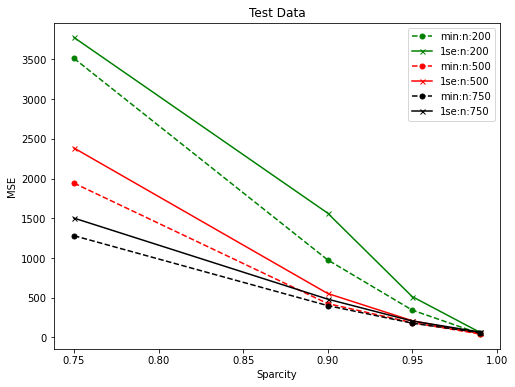

In [5]:

n = [200, 500, 750]
sparsity_val = [0.75, 0.9, 0.95, 0.99]
SNR = 2
beta_scale = 5
rng = np.random.default_rng(42)
n_rep = 5


def get_MSE_test(alpha):
    mse = linear_model.Lasso(alpha=alpha).fit(X_train,y_train)
    y_pred = mse.predict(X_test)
    return mean_squared_error(y_test, y_pred)

def get_alpha(lasso):
    cv_mean = np.mean(lasso.mse_path_, axis=1)
    cv_std = np.std(lasso.mse_path_, axis=1)
    idx_min_mean = np.argmin(cv_mean)
    idx_alpha = np.where(
        (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean]) &
        (cv_mean >= cv_mean[idx_min_mean]))[0][0]
    alpha_lse = lasso.alphas_[idx_alpha]
    alpha_min = lasso.alpha_
    return alpha_min, alpha_lse


def get_parameters(actual,estimated):
    TP = FN = FP = TN = 0
    for i in range(0, len(actual)):
        if actual[i] == 1 and estimated[i] == 1:
            TP += 1
        if actual[i] == 1 and estimated[i] == 0: 
            FN += 1
        if  actual[i] == 0 and estimated[i] == 1:
            FP += 1
        if actual[i] == 0 and estimated[i] == 0:
            TN += 1
        try:
            Sensitivity = TP /(TP + FN)
            Specificity = TN /(TN +FP)
        except ZeroDivisionError:
            Sensitivity = 0 
            Specificity = 0
    return Sensitivity, Specificity


def digitsToOnes(array):
    indices = np.nonzero(array)
    array[indices] = 1
    final_vector = array
    return final_vector



MSE_min = np.zeros((len(n),len(sparsity_val)))
MSE_1se = np.zeros((len(n),len(sparsity_val)))
sens_min = np.zeros((len(n),len(sparsity_val)))
sens_1se = np.zeros((len(n),len(sparsity_val)))
spec_1se = np.zeros((len(n),len(sparsity_val)))
spec_min = np.zeros((len(n),len(sparsity_val)))


for i in range(0,len(n)):
    for j in range(0,len(sparsity_val)):
        _min_MSE = np.zeros(n_rep)
        _1se_MSE = np.zeros(n_rep)
        sens_1se_Mat = np.zeros(n_rep)
        spec_1se_Mat = np.zeros(n_rep)
        sens_min_Mat = np.zeros(n_rep)
        spec_min_Mat = np.zeros(n_rep)
        
        for k in range(0,n_rep):

            X,y,beta = simulate_data(n[i],500,rng,sparsity=sparsity_val[j], SNR=SNR, beta_scale=beta_scale)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            lasso = LassoCV(cv=10)
            lasso.fit(X_train,y_train)

            alpha_min, alpha_lse = get_alpha(lasso)

            _min_MSE[k] = get_MSE_test(alpha_min)
            _1se_MSE[k] = get_MSE_test(alpha_lse)

            true_values = digitsToOnes(beta)

            lasso_1se = linear_model.Lasso(alpha=np.mean(alpha_min)).fit(X_train,y_train)
            lasso_min = linear_model.Lasso(alpha=np.mean(alpha_lse)).fit(X_train,y_train)
            beta_1se = digitsToOnes(lasso_1se.coef_)
            beta_min = digitsToOnes(lasso_min.coef_)

            sens_1se_Mat[k], spec_1se_Mat[k]  = get_parameters(true_values, beta_1se)
            sens_min_Mat[k], spec_min_Mat[k]  = get_parameters(true_values, beta_min)

        MSE_min[i,j] = _min_MSE.mean()
        MSE_1se[i,j] = _1se_MSE.mean()
        sens_min[i,j] = sens_min_Mat.mean()
        sens_1se[i,j] = sens_1se_Mat.mean()
        spec_min[i,j] = spec_min_Mat.mean()
        spec_1se[i,j] = spec_1se_Mat.mean()
        

f= plt.figure(figsize=(8,6))
plt.plot(sparsity_val,MSE_min[0],color='green',marker="o",markersize=5,label="min:n:200",linestyle='--')
plt.plot(sparsity_val,MSE_1se[0],color='green',marker="x",markersize=5,label="1se:n:200")
plt.plot(sparsity_val,MSE_min[1],color='red',marker="o",markersize=5,label="min:n:500",linestyle='--')
plt.plot(sparsity_val,MSE_1se[1],color='red',marker="x",markersize=5,label="1se:n:500")
plt.plot(sparsity_val,MSE_min[2],color='black',marker="o",markersize=5,label="min:n:750",linestyle='--')
plt.plot(sparsity_val,MSE_1se[2],color='black',marker="x",markersize=5,label="1se:n:750")
plt.xlabel("Sparcity")
plt.ylabel("MSE")
plt.title("Test Data")
plt.legend()




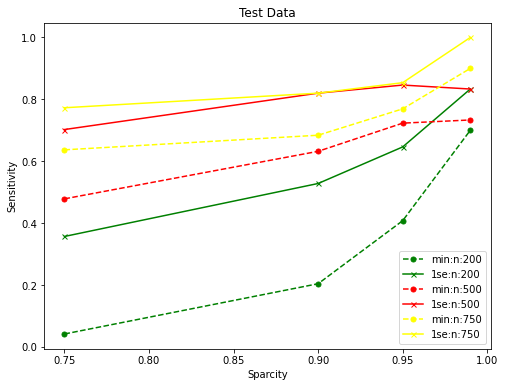

In [4]:
plt.figure(figsize=(8,6))
plt.plot(sparsity_val,sens_min[0],color='green',marker="o",markersize=5,label="min:n:200",linestyle='--')
plt.plot(sparsity_val,sens_1se[0],color='green',marker="x",markersize=5,label="1se:n:200")
plt.plot(sparsity_val,sens_min[1],color='red',marker="o",markersize=5,label="min:n:500",linestyle='--')
plt.plot(sparsity_val,sens_1se[1],color='red',marker="x",markersize=5,label="1se:n:500")
plt.plot(sparsity_val,sens_min[2],color='yellow',marker="o",markersize=5,label="min:n:750",linestyle='--')
plt.plot(sparsity_val,sens_1se[2],color='yellow',marker="x",markersize=5,label="1se:n:750")
plt.xlabel("Sparcity")
plt.ylabel("Sensitivity")
plt.title("Test Data")
plt.legend()

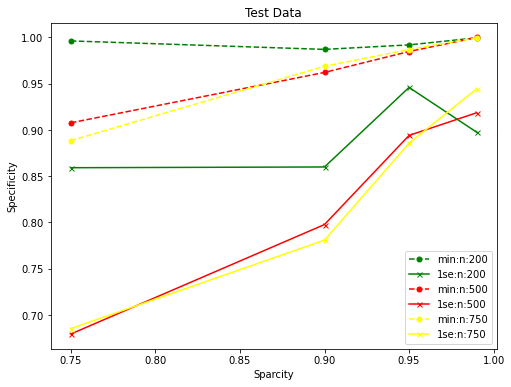

In [6]:
plt.figure(figsize=(8,6))
plt.plot(sparsity_val,spec_min[0],color='green',marker="o",markersize=5,label="min:n:200",linestyle='--')
plt.plot(sparsity_val,spec_1se[0],color='green',marker="x",markersize=5,label="1se:n:200")
plt.plot(sparsity_val,spec_min[1],color='red',marker="o",markersize=5,label="min:n:500",linestyle='--')
plt.plot(sparsity_val,spec_1se[1],color='red',marker="x",markersize=5,label="1se:n:500")
plt.plot(sparsity_val,spec_min[2],color='yellow',marker="o",markersize=5,label="min:n:750",linestyle='--')
plt.plot(sparsity_val,spec_1se[2],color='yellow',marker="x",markersize=5,label="1se:n:750")
plt.xlabel("Sparcity")
plt.ylabel("Specificity")
plt.title("Test Data")
plt.legend()

## Simulation on Train Data

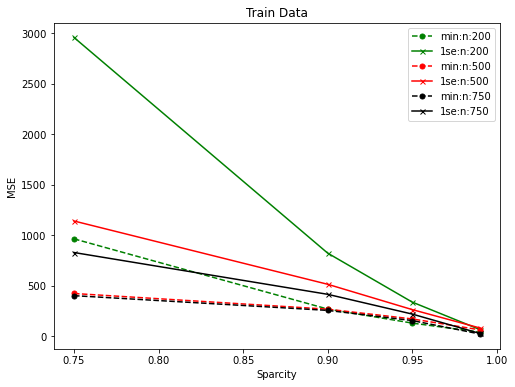

In [7]:
def get_MSE_train(alpha):
    mse = linear_model.Lasso(alpha=alpha).fit(X_train,y_train)
    y_pred = mse.predict(X_train)
    return mean_squared_error(y_train, y_pred)

MSE_min = np.zeros((len(n),len(sparsity_val)))
MSE_1se = np.zeros((len(n),len(sparsity_val)))
sens_min = np.zeros((len(n),len(sparsity_val)))
sens_1se = np.zeros((len(n),len(sparsity_val)))
spec_1se = np.zeros((len(n),len(sparsity_val)))
spec_min = np.zeros((len(n),len(sparsity_val)))


for i in range(0,len(n)):
    for j in range(0,len(sparsity_val)):
        _min_MSE = np.zeros(n_rep)
        _1se_MSE = np.zeros(n_rep)
        sens_1se_Mat = np.zeros(n_rep)
        spec_1se_Mat = np.zeros(n_rep)
        sens_min_Mat = np.zeros(n_rep)
        spec_min_Mat = np.zeros(n_rep)

        for k in range(0,n_rep):

            X,y,beta = simulate_data(n[i],500,rng,sparsity=sparsity_val[j], SNR=SNR, beta_scale=beta_scale)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            lasso = LassoCV(cv=10)
            lasso.fit(X_train,y_train)

            alpha_min, alpha_lse = get_alpha(lasso)

            _min_MSE[k] = get_MSE_train(alpha_min)
            _1se_MSE[k] = get_MSE_train(alpha_lse)

            true_values = digitsToOnes(beta)

            lasso_1se = linear_model.Lasso(alpha=np.mean(alpha_min)).fit(X_train,y_train)
            lasso_min = linear_model.Lasso(alpha=np.mean(alpha_lse)).fit(X_train,y_train)
            beta_1se = digitsToOnes(lasso_1se.coef_)
            beta_min = digitsToOnes(lasso_min.coef_)

            sens_1se_Mat[k], spec_1se_Mat[k]  = get_parameters(true_values, beta_1se)
            sens_min_Mat[k], spec_min_Mat[k]  = get_parameters(true_values, beta_min)

        MSE_min[i,j] = _min_MSE.mean()
        MSE_1se[i,j] = _1se_MSE.mean()
        sens_min[i,j] = sens_min_Mat.mean()
        sens_1se[i,j] = sens_1se_Mat.mean()
        spec_min[i,j] = spec_min_Mat.mean()
        spec_1se[i,j] = spec_1se_Mat.mean()


f= plt.figure(figsize=(8,6))
plt.plot(sparsity_val,MSE_min[0],color='green',marker="o",markersize=5,label="min:n:200",linestyle='--')
plt.plot(sparsity_val,MSE_1se[0],color='green',marker="x",markersize=5,label="1se:n:200")
plt.plot(sparsity_val,MSE_min[1],color='red',marker="o",markersize=5,label="min:n:500",linestyle='--')
plt.plot(sparsity_val,MSE_1se[1],color='red',marker="x",markersize=5,label="1se:n:500")
plt.plot(sparsity_val,MSE_min[2],color='black',marker="o",markersize=5,label="min:n:750",linestyle='--')
plt.plot(sparsity_val,MSE_1se[2],color='black',marker="x",markersize=5,label="1se:n:750")
plt.xlabel("Sparcity")
plt.ylabel("MSE")
plt.title("Train Data")
plt.legend()

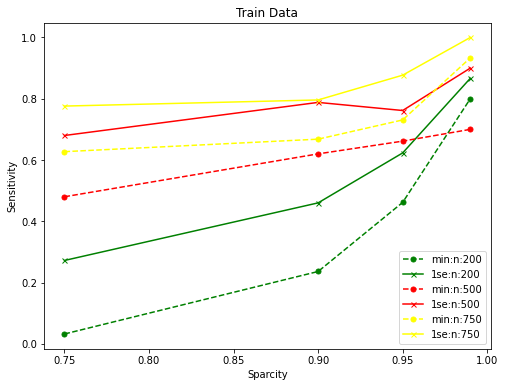

In [8]:
plt.figure(figsize=(8,6))
plt.plot(sparsity_val,sens_min[0],color='green',marker="o",markersize=5,label="min:n:200",linestyle='--')
plt.plot(sparsity_val,sens_1se[0],color='green',marker="x",markersize=5,label="1se:n:200")
plt.plot(sparsity_val,sens_min[1],color='red',marker="o",markersize=5,label="min:n:500",linestyle='--')
plt.plot(sparsity_val,sens_1se[1],color='red',marker="x",markersize=5,label="1se:n:500")
plt.plot(sparsity_val,sens_min[2],color='yellow',marker="o",markersize=5,label="min:n:750",linestyle='--')
plt.plot(sparsity_val,sens_1se[2],color='yellow',marker="x",markersize=5,label="1se:n:750")
plt.xlabel("Sparcity")
plt.ylabel("Sensitivity")
plt.title("Train Data")
plt.legend()


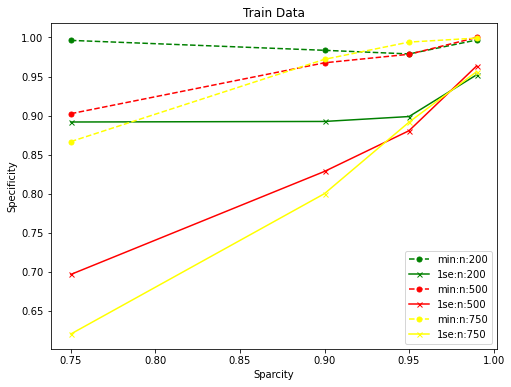

In [9]:
plt.figure(figsize=(8,6))
plt.plot(sparsity_val,spec_min[0],color='green',marker="o",markersize=5,label="min:n:200",linestyle='--')
plt.plot(sparsity_val,spec_1se[0],color='green',marker="x",markersize=5,label="1se:n:200")
plt.plot(sparsity_val,spec_min[1],color='red',marker="o",markersize=5,label="min:n:500",linestyle='--')
plt.plot(sparsity_val,spec_1se[1],color='red',marker="x",markersize=5,label="1se:n:500")
plt.plot(sparsity_val,spec_min[2],color='yellow',marker="o",markersize=5,label="min:n:750",linestyle='--')
plt.plot(sparsity_val,spec_1se[2],color='yellow',marker="x",markersize=5,label="1se:n:750")
plt.xlabel("Sparcity")
plt.ylabel("Specificity")
plt.title("Train Data")
plt.legend()

## Part 2

In [1]:
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd

In [2]:
X = pd.read_csv("data.csv", index_col=0)
X

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.000000
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.000000
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.000000
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.000000
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,0.0,...,6.088133,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000
sample_797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,0.0,...,6.371876,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000
sample_798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,0.0,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
sample_799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,0.0,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000


In [3]:
y = pd.read_csv("labels.csv", index_col=0)
#y = y.to_numpy
y

,Class
sample_0,PRAD
sample_1,LUAD
sample_2,PRAD
sample_3,PRAD
sample_4,BRCA
...,...
sample_796,BRCA
sample_797,LUAD
sample_798,COAD
sample_799,PRAD


## 1. Feature Reduction

In [4]:
X_mod = SelectKBest(k=200).fit_transform(X,y)

C:\Users\Ashwin\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Ashwin\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [    5    23  4370  4808  4809  4814  4816  4817  4831  5288  7661  7662
  7663  7664  7665  8121  9304  9306  9314  9316  9320  9452 10121 11958
 13991 14158 14159 14161 15138 15140 15141 15446 16566 16568 16569 16571
 16575 16578 16579 16604 16634 16637 16677 16697 16698 16699 16700 16701
 16702 16704 16705 16706 16707 16708 16709 16710 16711 16712 16713 16714
 16715 16716 16717 16718 16719 16720 16721 16722 16723 16724 16725 16726
 16727 16728 16729 16730 16731 16732 16733 16734 16735 16736 16737 16738
 16739 16740 16741 16742 16743 16744 16745 16746 16748 16749 16750 16751
 16752 16753 16754 16756 16757 16758 1675

In [5]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split


## 2. Performing feature selection

## Logistic Regression with CV

In [8]:
from sklearn.metrics import balanced_accuracy_score
all_c = np.logspace(-4,4,30)

In [9]:
def logRegression(X_values,Y_values):
    X_train,X_test,y_train,y_test = train_test_split(X_values,Y_values,test_size = 0.2, random_state=42)
    lr_cv = LogisticRegressionCV(solver='liblinear', random_state=0, multi_class='ovr', Cs=np.logspace(-4,4,30), intercept_scaling=10000, penalty='l1',
                              scoring='balanced_accuracy')
    y_train = np.ravel(y_train)
    lr_cv.fit(X_train,y_train)
    
    array_coad = lr_cv.scores_["COAD"]
    array_brca = lr_cv.scores_["BRCA"]
    array_kirc = lr_cv.scores_["KIRC"]
    array_luad = lr_cv.scores_["LUAD"]
    array_prad = lr_cv.scores_["PRAD"]
    all_class = [array_coad,array_brca,array_kirc,array_luad,array_prad]
    
    all_class_avg = []
    
    for g in range(0,len(all_class)):
        all_class_avg.append(np.mean(all_class[g], axis=0))
    all_class_comb = np.mean(all_class_avg, axis=0)
    
    
    score_std = np.std(all_class_comb)
    idx_Cmax = np.argmax(all_class_comb)
    idx_C1se = np.where(
        (all_c <= all_c[idx_Cmax] ) &
        (all_c >= all_c[idx_Cmax]- all_c[idx_Cmax])
    )[0][0]
    C_1se = all_c[idx_C1se]
    Cmax = all_c[idx_Cmax]
    
    
    lr = LogisticRegression(solver='liblinear', random_state=0, multi_class='ovr', C=Cmax, intercept_scaling=10000, penalty='l1')
    lr.fit(X_values,Y_values)
    all_coef = lr.coef_
    
    
    for t in range(len(all_coef)):
        for s in range(all_coef.shape[1]):
            if all_coef[t][s]!=0:
                all_coef[t][s] = 1
    
    ImpMat = all_coef            
    
    
    return ImpMat


In [10]:
all_coef

NameError: name 'all_coef' is not defined

## 3.  Gaining confidence in the selection

In [11]:
final_impact = np.zeros((5,200))
for i in range(50):
    n,f = X_mod.shape
    idx = np.random.choice(n,size=math.floor(0.8*n),replace= True)
    new_X = X_mod[idx]
    new_y = np.ravel(y)[idx]
    impactMatrix = logRegression(new_X,new_y)
    final_impact = final_impact + impactMatrix

In [25]:
indices_final = []
for t in range(0,len(final_impact)):
    indices = (-final_impact[t]).argsort()[:5]
    indices_final.append(indices)
indices_final    

[array([ 86, 180, 102, 169,  75], dtype=int64),
 array([121,  79,  38,  34,  65], dtype=int64),
 array([ 33,  71,  40, 167,  69], dtype=int64),
 array([153, 149,  99,  65,  70], dtype=int64),
 array([ 98,  97, 137, 194, 186], dtype=int64)]

In [26]:
classes = np.asarray([1,2,3,4,5])

In [27]:
classes

array([1, 2, 3, 4, 5])

In [28]:
indices_final[1]

array([121,  79,  38,  34,  65], dtype=int64)

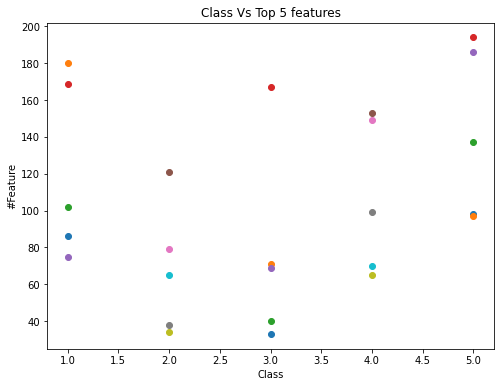

In [31]:
plt.figure(figsize=(8,6))
plt.xlabel("Class")
plt.ylabel("#Feature")
plt.title("Class Vs Top 5 features")
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.scatter(classes[i],indices_final[i][j],)
        
        